<a href="https://colab.research.google.com/github/Jerry0209/FundamentalLearningEPFL/blob/main/TP6/regularized_linear_regression_v2_Jerry_noted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE-411 Fundamentals of inference and learning, EPFL
## Exercise Session 6: Ridge Regression and Lasso on real datasets

In this sixth set of exercises, we will see how to implement the methods introduced in the last exercise session and discussed in the last lecture to work with some real datasets. We will see which are the differences between these regularized least-square methods and the standard OLS solution.

**What you will learn today:**  In this sixth notebook, we shall see how to use scikit-learn to implement Ridge and Lasso. We also introduce `pipelines`, an important tool which is frequently used in Machine Learning. Furthermore, we will linger on the important concept of sparsity.

In [1]:
#We import the usual packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A) Ozone
---
Let us look at a particular real-life data problem. In the following example we take the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.

#### Dataset loading

In [2]:
data =   pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ozone     330 non-null    int64
 1   vh        330 non-null    int64
 2   wind      330 non-null    int64
 3   humidity  330 non-null    int64
 4   temp      330 non-null    int64
 5   ibh       330 non-null    int64
 6   dpg       330 non-null    int64
 7   ibt       330 non-null    int64
 8   vis       330 non-null    int64
 9   doy       330 non-null    int64
dtypes: int64(10)
memory usage: 25.9 KB


Alright, we're ready to get started! Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to split it into three parts: **Training**(and within that, **Validation**), and **Testing** sets.

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

#### Train/Test splitting

In [ ]:
from sklearn.model_selection import train_test_split

#--- Convert from DataFrame to NDArray ---#
# We also ensure that we load in all data as floating point values
# so that we don't miss anything to truncations.
y = data['ozone'].to_numpy().astype(float)
X = data[data.columns[1:]].to_numpy()

#--- Split Dataset ---#
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  247
Testing  Samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown off by large differences in scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features to do this automatically!

#### Preprocessing

In [ ]:
from sklearn import preprocessing

#--- Scaling ---#
scaler = preprocessing.StandardScaler().fit(XTrain)
XTest_scaled = scaler.transform(XTest)
XTrain_scaled = scaler.transform(XTrain)

#--- Center observations (simplify the OLS)---#
yTrain_mean = np.mean(yTrain)
yTrain_centered = yTrain - yTrain_mean

Now it is time for us to choose our estimator. What should we choose?

## Attempt 1: ordinary least squares (OLS)
---



If you remember last exercise session, the equation to solve is of the type

$$
(X^T X) \hat {\mathbf w} = X^T {\mathbf y}
$$

The function `linalg.solve(a,b)` can be used to solve a system of linear scalar equations $ax=b$, thus we can use it to compute the prediction of the model both on the train and on the test datasets

In [ ]:
#--- Compute the OLS Estimate ---#
regOLS = np.linalg.solve(np.dot(XTrain_scaled.T,XTrain_scaled), np.dot(XTrain_scaled.T,yTrain))

yp = np.dot(XTrain_scaled, regOLS)
ypTest = np.dot(XTest_scaled, regOLS)

Let's see now how well the prediction performance looks and which are the learned parameters corresponding to the OLS solution

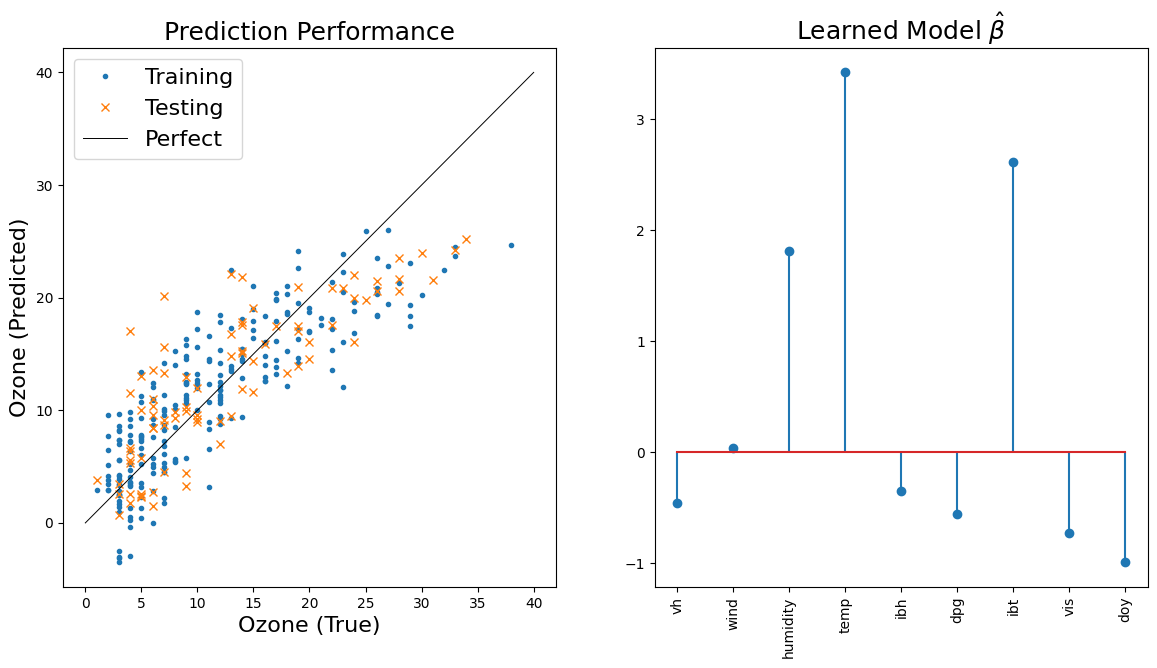

In [ ]:
#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp+ yTrain_mean,'.', label='Training') #remember to add again the mean when you plot
plt.plot(yTest, ypTest+ yTrain_mean, label='Testing', marker='x', ls='')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regOLS)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');

Finally, to see how well the model is performing, we can compute the Residual Sum of Squares (RSS) for both the train and the test set

In [ ]:
#--- Print RSS ---#
rss_train = np.mean(np.power(yTrain_centered - yp,2))
rss_test = np.mean(np.power(yTest - yTrain_mean - ypTest,2))
print("Normalized RSS (Train): %0.2f" % rss_train)
print("Normalized RSS  (Test): %0.2f" % rss_test)

Normalized RSS (Train): 18.28
Normalized RSS  (Test): 22.53


The same thing could have been done using the packages present in **Scikit-Learn**

In [ ]:
from sklearn import linear_model

#--- Define OLS Estimator ---#
regL = linear_model.LinearRegression()
#--- Fit the parameters ---#
regL.fit(XTrain_scaled,yTrain_centered)
#--- Use the learned coefficients to predict the y ---#
yp_L = regL.predict(XTrain_scaled)
ypTest_L = regL.predict(XTest_scaled)

**Note:** the standard value `fit_intercept=True` in `LinearRegression`, but also in `Ridge` and in `Lasso`, allows us not to think about the intercept, since it is automatically considered by the method.

#### 1) Compare these estimates to the preivious ones, computed without considering the intercept. Why they are so similar?
 - Is the intercept fitted by `LinearRegression` big?
 - What's the difference in the MSE of the two prediction?
 - (bonus) Make a plot!



    - **Why are they so similar? / Is the intercept big?**
    The estimates (coefficients) are so similar because the intercept fitted by `LinearRegression` is **very small (close to zero)**. When the intercept is negligible, the model with an intercept (`fit_intercept=True`) becomes almost identical to the model forced to have no intercept (`fit_intercept=False`). This often happens if the data was centered (mean subtracted) before modeling.

    - **What's the difference in the MSE?**
    The difference in the Mean Squared Error (MSE) between the two predictions will be **extremely small, near zero**. Since the coefficients and intercept are so similar, the predictions from both models will be nearly identical, leading to a negligible difference in their error.

Normalized RSS (Train) - Manual: 18.28
Normalized RSS (Train) - Sklearn: 18.28
Normalized RSS (Test) - Manual: 22.53
Normalized RSS (Test) - Sklearn: 22.53

Intercept fitted by LinearRegression: -0.00
Difference in Train RSS: 0.00
Difference in Test RSS: -0.00


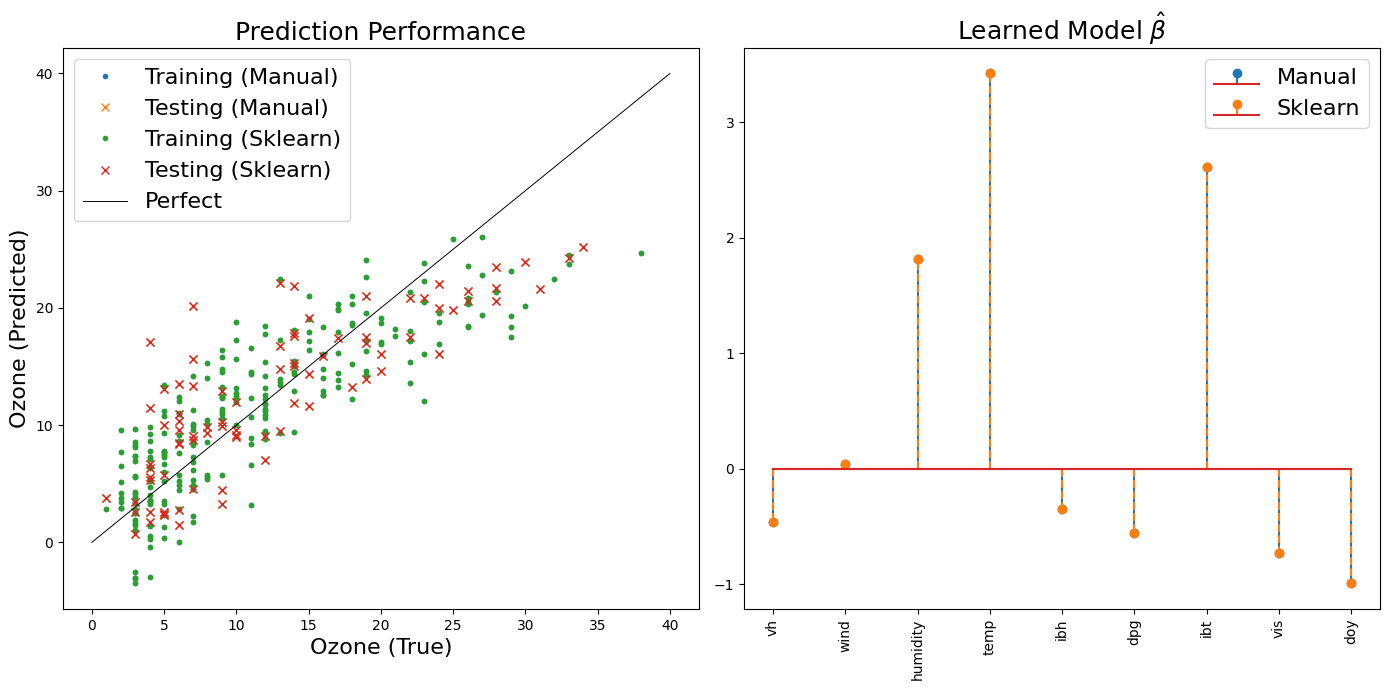

In [ ]:
# Compare the manually calculated RSS with the scikit-learn RSS
rss_train_L = np.mean(np.power(yTrain_centered - yp_L, 2))
rss_test_L = np.mean(np.power(yTest - yTrain_mean - ypTest_L, 2))

print("Normalized RSS (Train) - Manual: %0.2f" % rss_train)
print("Normalized RSS (Train) - Sklearn: %0.2f" % rss_train_L)
print("Normalized RSS (Test) - Manual: %0.2f" % rss_test)
print("Normalized RSS (Test) - Sklearn: %0.2f" % rss_test_L)

# Check the intercept fitted by LinearRegression
print("\nIntercept fitted by LinearRegression: %0.2f" % regL.intercept_)

# Calculate the difference in MSE (which is the same as RSS since we are using mean)
print("Difference in Train RSS: %0.2f" % (rss_train - rss_train_L))
print("Difference in Test RSS: %0.2f" % (rss_test - rss_test_L))


# Plot the prediction performance for both methods
plt.figure(figsize=(14,7))

plt.subplot(121)
plt.plot(yTrain, yp + yTrain_mean, '.', label='Training (Manual)')
plt.plot(yTest, ypTest + yTrain_mean, 'x', label='Testing (Manual)')
plt.plot(yTrain, yp_L + yTrain_mean, '.', label='Training (Sklearn)')
plt.plot(yTest, ypTest_L + yTrain_mean, 'x', label='Testing (Sklearn)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

plt.subplot(122)
plt.stem(regOLS, label='Manual')
plt.stem(regL.coef_, linefmt='C1--', markerfmt='C1o', label='Sklearn')
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');
plt.legend(loc=1, fontsize=16)

plt.tight_layout()
plt.show()

#### 2) Prove that fitting the intercept (as `LinearRegression`) is equivalent to what we did (subtracting the mean). (Hint: remember that the inputs are scaled!)

## Attempt 2: Ridge Regression
---

For RR, that we implemented by hand in the last notebook, we can use directly Scikit-learn. First of all, we import as always the model, choosing for now the regularization constant $\alpha = 0.01$

In [ ]:
#--- Define Regression Estimator ---#
regRR = linear_model.Ridge(alpha=0.01)

Now, we need to perform some kind of cross-validation (CV) to find the best set of parameters for our model. We will do this by constructing a **Pipeline**. A pipeline is a useful way of handling pre-processing on separate data partitions when performing CV. Let's take a look at that.

In the next cell we use the pipeline to do two things:

* We standardize features by removing the mean and scaling to unit variance (it is done by `preprocessing.StandardScaler()`)

* We implement the fitting strategy; namely Ridge Regression

#### Pipeline

In [ ]:
from sklearn.pipeline import make_pipeline

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR) # Two consecutive transformation

After that, we have  to define a Scoring Metric. In this case, to compare the fits we look at the prediction error via the RSS.

In [ ]:
#--- Define a Scoring Metric (Residual Sum of Squares) ---#
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

 We can then create an iterator which performs a set of **randomized splits on the dataset into "train" and "validation"**.

Obviously, we have a trade-off between the test set size and the number of splits we should perform.

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=30, test_size=0.05, random_state=1)

#--- Define the Parameters to Search ---#
param_grid = [
    {'ridge__alpha': np.logspace(-5,3,100)} # we do CV for values of alpha between 0.0001 and 1000
]

Finally, we use `GridSearchCV` to find which is the best value of the parameter $\alpha$

In [ ]:
#--- Define CV ---#
cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv,return_train_score=True) #Note that we need to use the RSS with a minus sign!

# class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

In [ ]:
#--- Run CV ---#
cv_regRR.fit(XTrain,yTrain)

GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=0.01))]),
             param_grid=[{'ridge__alpha': array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05,...
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03])}],
             return_train_score=True,
             scoring=<function neg_rss at 0x7ab6f19c4540>)

Great! Now lets take a look at the performance of our estimator. Here, for example of Ridge regression, we chart over the $\alpha$ parameter that we perform CV against.

First of all, we save in `cvOptAlpha` the optimal regularization parameter $\alpha$ found by the grid search, and in `cvOptParams` the corresponding parameters

In [ ]:
#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams = cv_regRR.best_estimator_['ridge'].coef_

In [ ]:
cvOptAlpha

np.float64(11.49756995397738)

Then, we can plot the performance versus the regularization parameter $\alpha$

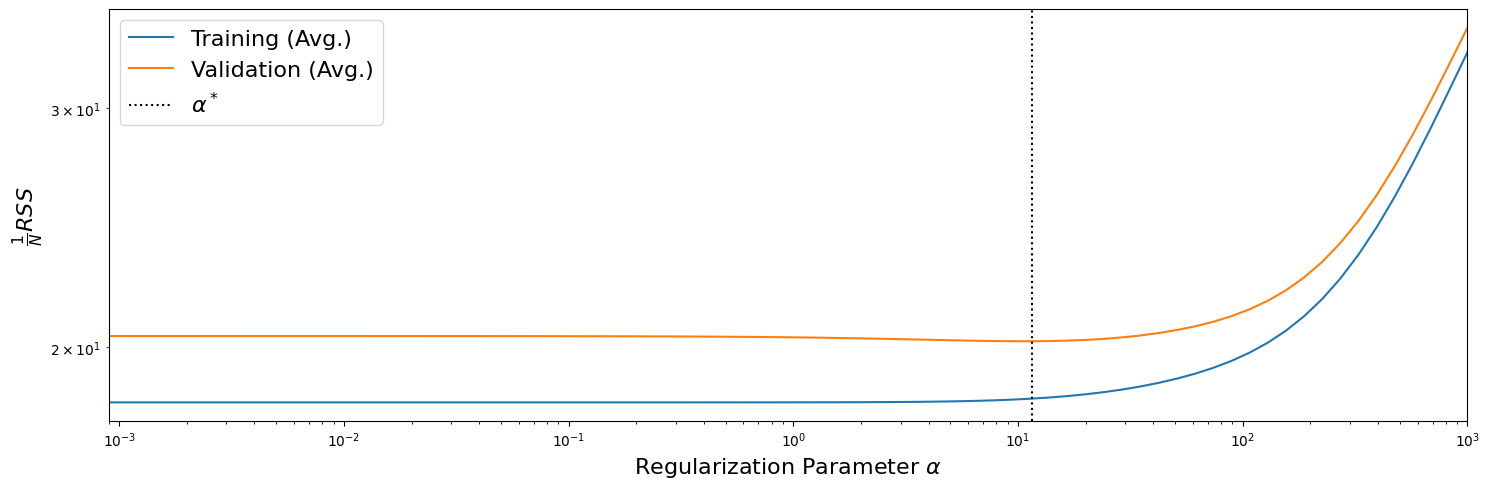

In [ ]:
#--- Visualize ---#
testedAlpha = cv_regRR.cv_results_['param_ridge__alpha']
trainScores = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regRR.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-3, 1e3])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

好的，Attemp 2: Ridge Regression (岭回归) 的整个流程是为了解决一个在机器学习中非常常见的问题：**如何选择模型的“超参数” (hyperparameter)**。

在第一部分 (Attempt 1) 中，你使用了标准的普通最小二乘法 (OLS)，它没有超参数。但在第二部分 (Attempt 2) 中，你使用了岭回归 (Ridge Regression)，它有一个关键的超参数 $\alpha$（阿尔法），这个 $\alpha$ 控制着正则化的强度。

  * $\alpha$ 太小，模型就接近 OLS，可能会“过拟合” (overfitting)，在训练数据上表现很好，但在新数据上表现很差。
  * $\alpha$ 太大，模型会“欠拟合” (underfitting)，对所有数据的表现都可能很差。

因此，**Attempt 2 的核心目标是：通过交叉验证 (Cross-Validation) 来自动找到最佳的 $\alpha$ 值**，以建立一个在新数据上表现最好的模型。

-----

### 🔎 为什么这么操作？详细流程分解

这是 notebook 中 Attempt 2 的完整步骤和“为什么”这么做的解释：

#### 步骤 1：建立一个“流水线” (Pipeline)

这个流程的第一步是建立一个 `Pipeline`。

  * **操作 (Cell 25):**
    ```python
    pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)
    ```
  * **为什么这么做？**
      * **标准化 (StandardScaler):** 岭回归和Lasso对特征的尺度（大小范围）很敏感。如果一个特征的数值很大（比如 1000），而另一个很小（比如 0.1），模型会不公平地惩罚那个数值大的特征。因此，在拟合模型之前，必须先将所有特征“标准化”（即减去均值并除以标准差）。
      * **流水线 (Pipeline):** 你不能在*所有*数据上做标准化。如果你在分割数据*之前*就对所有数据（包括训练集和验证集）进行了标准化，那么验证集的信息（它的均值和标准差）就“泄漏”到了训练过程中。这会导致模型看起来比实际上更好，是一种作弊。
      * `Pipeline` 将“标准化”和“岭回归”捆绑在一起。在稍后的交叉验证中，它会**自动**做到：仅在训练数据上计算均值和标准差，然后用这个标准去转换训练数据*和*验证数据。这完美地防止了数据泄漏。

#### 步骤 2：定义交叉验证 (CV) 的策略和参数

我们需要一种方法来模拟“新数据”，并测试一系列的 $\alpha$ 值。

  * **操作 (Cell 29):**

    1.  `cv = ShuffleSplit(...)`：创建了一个“随机分割”策略。它会把你的训练集 (`XTrain`) 随机打乱并分割 30 次。在每一次分割中，它会取出 5% 的数据作为“验证集”（模拟新数据），剩下的 95% 作为“（次级）训练集”。
    2.  `param_grid = [{'ridge__alpha': np.logspace(-5, 3, 100)}]`：定义了要搜索的 $\alpha$ 范围。这里它创建了 100 个 $\alpha$ 值，从 $10^{-5}$ (0.00001) 到 $10^3$ (1000) 之间。

  * **为什么这么做？**
    我们使用 30 次随机分割（而不是只分一次），是为了得到一个更稳定、更可靠的性能评估。如果只分割一次，你可能碰巧选到一组“容易”或“困难”的验证数据，导致 $\alpha$ 的选择有偏差。30 次的平均结果更可信。

#### 步骤 3：定义评分标准

`GridSearchCV` 需要知道什么是“好”的模型。

  * **操作 (Cell 27):**
    ```python
    def neg_rss(reg, X, y):
        yp = reg.predict(X)
        return -np.mean(np.power(y - yp, 2))
    ```
  * **为什么这么做？**
    我们希望模型的“残差平方和” (RSS) 越低越好。但是，Scikit-learn 的 `GridSearchCV` 默认是去*最大化* (maximize) 一个分数。为了解决这个问题，我们定义了一个“负的 RSS” (`neg_rss`)。最大化 `neg_rss` 就等同于最小化 RSS。

#### 步骤 4：执行网格搜索 (Grid Search)

这是最关键的一步，它把前面所有的东西组合起来并运行。

  * **操作 (Cell 31 & 32):**

    1.  `cv_regRR = GridSearchCV(pipe_regRR, ...)`：设置 `GridSearchCV` 对象，告诉它要用哪个流水线 (`pipe_regRR`)、哪个参数网格、哪个评分标准 (`neg_rss`) 和哪个 CV 策略 (`cv`)。
    2.  `cv_regRR.fit(XTrain, yTrain)`：**运行搜索！**

  * **背后发生了什么？**
    当你运行 `.fit()` 时，`GridSearchCV` 内部执行了一个庞大的循环：

    1.  它从 100 个 $\alpha$ 值中取出第一个（比如 $\alpha = 0.00001$）。
    2.  它使用 `ShuffleSplit` 策略，进行第 1 次分割（95% 训练, 5% 验证）。
    3.  它在 95% 的数据上*拟合* `Pipeline`（先 `StandardScaler` 再 `Ridge(alpha=0.00001)`）。
    4.  它在 5% 的数据上*测试*，并用 `neg_rss` 记分。
    5.  它重复第 2-4 步共 30 次（因为 `n_splits=30`）。
    6.  它计算这个 $\alpha$ (0.00001) 在 30 次验证中的平均分。
    7.  它对*所有 100 个 $\alpha$ 值*重复步骤 1-6。
    8.  最后，它比较所有 100 个 $\alpha$ 的平均分，找出哪个 $\alpha$ 获得了最高分（即最低的 RSS）。这个 $\alpha$ 就是“最佳超参数”。

#### 步骤 5：分析结果和最终评估

在找到最佳 $\alpha$ 后（在这个 notebook 中是约 11.5），流程进入评估阶段。

  * **操作 (Cell 38):** 绘制了不同 $\alpha$ 值下的训练得分和验证得分。这可以让你直观地看到 $\alpha$ 是如何影响过拟合和欠拟合的。
  * **操作 (Cell 40):** 使用找到的最佳 $\alpha$ (`cvOptAlpha`) 在*全部* `XTrain` 数据上重新训练了模型，并展示了它在训练集上的预测效果。
  * **操作 (Cell 43):**
    1.  `ypTest = pipe_regRR.predict(XTest)`：这是最重要的一步评估。它使用刚才训练好的最佳模型，对你从一开始就“冷冻”起来的、模型从未见过的**测试集** (`XTest`) 进行预测。
    2.  计算并打印了在测试集上的 RSS (22.66)。
    3.  最后，它将这个结果与 Attempt 1 (OLS) 的 RSS (22.53) 进行了比较。

-----

### 总结

Attempt 2 的整个流程是一个**严谨的、自动化的超参数调优过程**。

它的目的不是手动选一个 $\alpha$，而是设计一个系统（结合 Pipeline, ShuffleSplit 和 GridSearchCV），让机器自动测试 100 个不同的 $\alpha$，并在 30 个不同的验证集上评估它们，最终选出那个**泛化能力最强**（即在模拟新数据时表现最好）的 $\alpha$。最后才用这个最佳模型去测试集上“交卷”。

Now, lets take a look at how well we are able to make our predictions on the training set using this CV optimal value of $\alpha$.

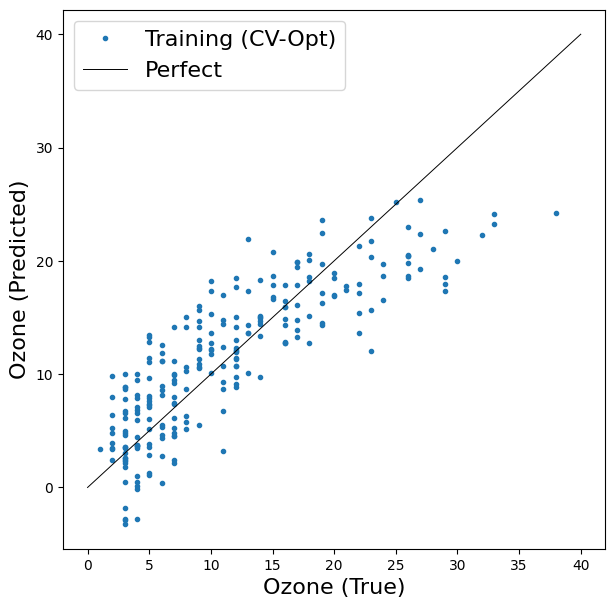

In [ ]:
#--- Get Training Predicitions ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha) # !!! how to pass parameters to pipelines
pipe_regRR.fit(XTrain, yTrain)
yp = pipe_regRR.predict(XTrain)

#--- Visualize ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

#### 3) Plot, as we previously did for OLS, the prediction performance and the learned parameters. After having done that, compute the RSS and compare it to the OLS one

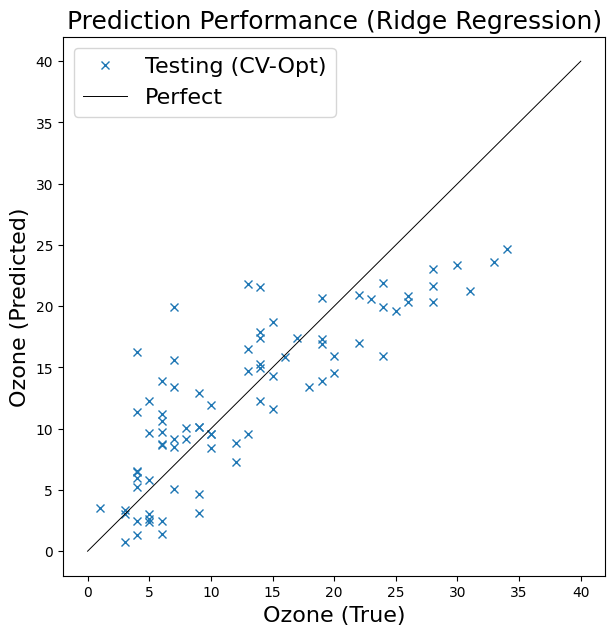

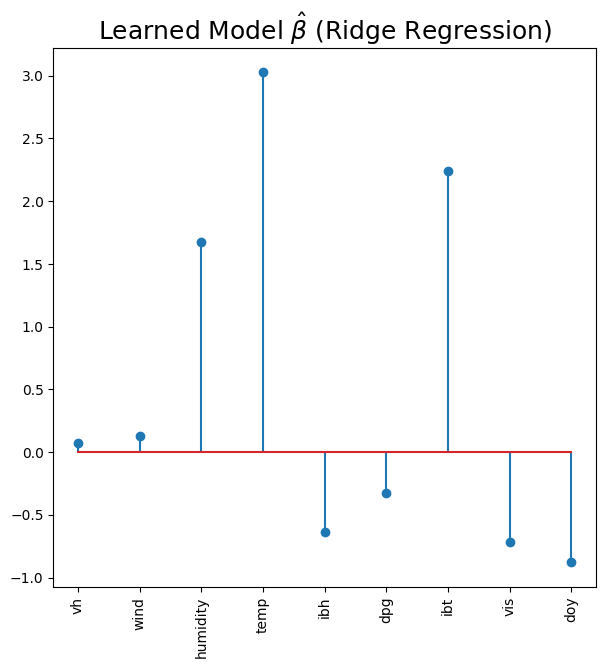

Normalized RSS (Train) - Ridge Regression: 18.38
Normalized RSS  (Test) - Ridge Regression: 22.66

Normalized RSS (Train) - OLS: 18.28
Normalized RSS  (Test) - OLS: 22.53


In [ ]:
#--- Get Test Predicitions ---#
ypTest = pipe_regRR.predict(XTest)

#--- Visualize Prediction Performance ---#
plt.figure(figsize=(7,7))
plt.plot(yTest, ypTest, 'x', label='Testing (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);
plt.title('Prediction Performance (Ridge Regression)', fontsize=18)
plt.show()


#--- Visualize Learned Parameters ---#
plt.figure(figsize=(7,7))
plt.stem(pipe_regRR['ridge'].coef_)
plt.title('Learned Model $\\hat{\\beta}$ (Ridge Regression)', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');
plt.show()


#--- Compute RSS ---#
rss_train_RR = np.mean(np.power(yTrain - yp,2)) # use yp from previous cell
rss_test_RR = np.mean(np.power(yTest - ypTest,2))

print("Normalized RSS (Train) - Ridge Regression: %0.2f" % rss_train_RR)
print("Normalized RSS  (Test) - Ridge Regression: %0.2f" % rss_test_RR)

# Compare with OLS RSS
print("\nNormalized RSS (Train) - OLS: %0.2f" % rss_train) # use rss_train from OLS section
print("Normalized RSS  (Test) - OLS: %0.2f" % rss_test)   # use rss_test from OLS section

## Attempt 3: Lasso
---


### 4) Your turn: using the `linear_model.Lasso` estimator present in Scikit-Learn,  repeat the steps done for Ridge Regression:
* Create the pipeline for preprocessing + regressor
* Do the Grid Search to find the optimal regularization parameter
* Visualize how the performance varies when we change the regularization parameter
* Plot the prediction performance and the learned parameters. What do you observe?
* Compute the RSS and compare it to the RR and the OLS one.

Optimal alpha for Lasso: 0.13219411484660315


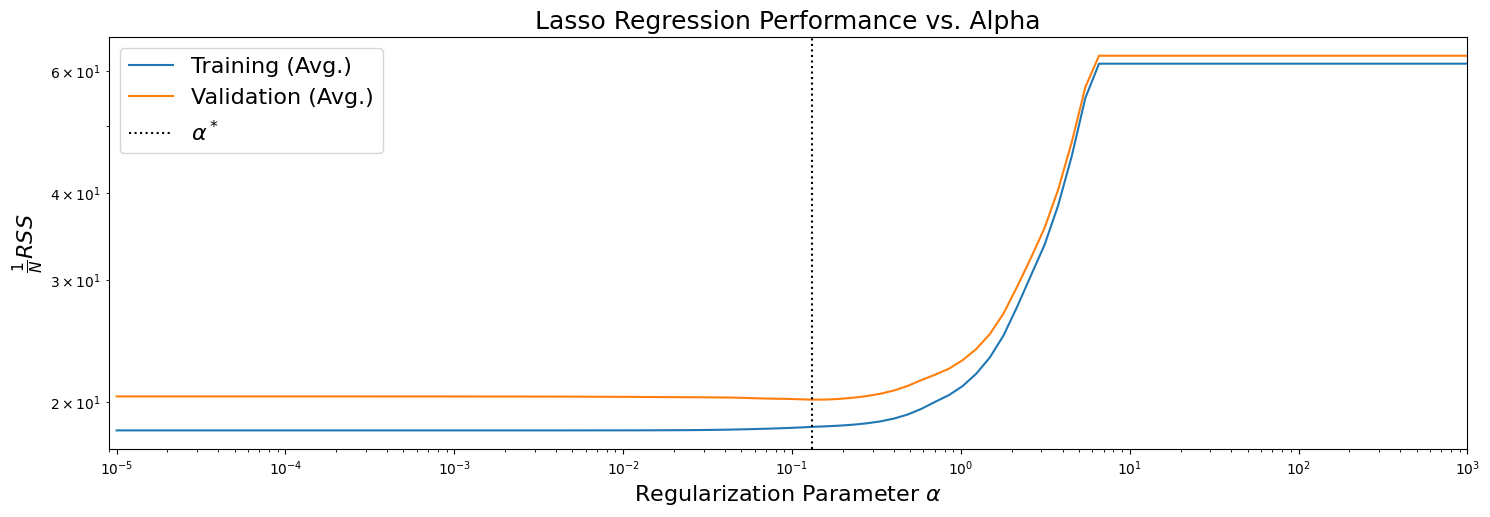

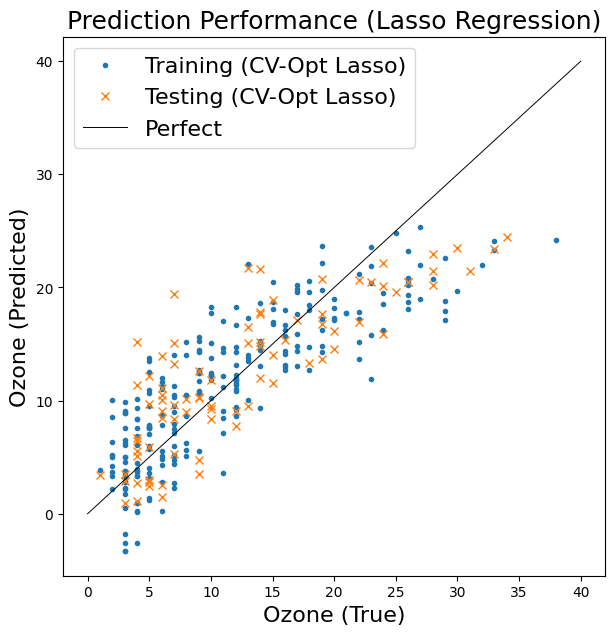

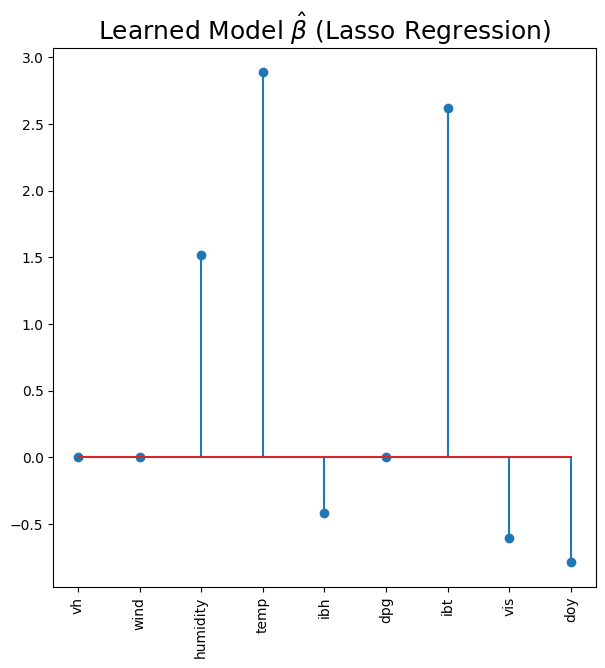

Normalized RSS (Train) - Lasso Regression: 18.48
Normalized RSS  (Test) - Lasso Regression: 22.16

Normalized RSS (Train) - OLS: 18.28
Normalized RSS  (Test) - OLS: 22.53

Normalized RSS (Train) - Ridge Regression: 18.38
Normalized RSS  (Test) - Ridge Regression: 22.66


In [ ]:
#--- Define Lasso Estimator ---#
regLasso = linear_model.Lasso(alpha=0.01)

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regLasso = make_pipeline(preprocessing.StandardScaler(), regLasso)

#--- Define the Parameters to Search ---#
param_grid_lasso = [
    {'lasso__alpha': np.logspace(-5, 3, 100)} # we do CV for values of alpha between 0.0001 and 1000
]

#--- Define CV ---#
cv_regLasso = GridSearchCV(pipe_regLasso, param_grid_lasso, scoring=neg_rss, cv=cv, return_train_score=True)

#--- Run CV ---#
cv_regLasso.fit(XTrain, yTrain)

#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha_Lasso = cv_regLasso.cv_results_['param_lasso__alpha'][cv_regLasso.best_index_]
cvOptParams_Lasso = cv_regLasso.best_estimator_['lasso'].coef_

print("Optimal alpha for Lasso:", cvOptAlpha_Lasso)

#--- Visualize Performance vs. Alpha ---#
testedAlpha_Lasso = cv_regLasso.cv_results_['param_lasso__alpha']
trainScores_Lasso = -cv_regLasso.cv_results_['mean_train_score']   # Reverse Sign
testScores_Lasso = -cv_regLasso.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha_Lasso, trainScores_Lasso, '-', label='Training (Avg.)')
plt.plot(testedAlpha_Lasso, testScores_Lasso, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha_Lasso, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-5, 1e3])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)
plt.title('Lasso Regression Performance vs. Alpha', fontsize=18)
plt.show()

#--- Get Training and Test Predictions ---#
pipe_regLasso.set_params(lasso__alpha=cvOptAlpha_Lasso)
pipe_regLasso.fit(XTrain, yTrain)
yp_Lasso_train = pipe_regLasso.predict(XTrain)
yp_Lasso_test = pipe_regLasso.predict(XTest)

#--- Visualize Prediction Performance ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain, yp_Lasso_train, '.', label='Training (CV-Opt Lasso)')
plt.plot(yTest, yp_Lasso_test, 'x', label='Testing (CV-Opt Lasso)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);
plt.title('Prediction Performance (Lasso Regression)', fontsize=18)
plt.show()


#--- Visualize Learned Parameters ---#
plt.figure(figsize=(7,7))
plt.stem(pipe_regLasso['lasso'].coef_)
plt.title('Learned Model $\\hat{\\beta}$ (Lasso Regression)', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');
plt.show()


#--- Compute RSS ---#
rss_train_Lasso = np.mean(np.power(yTrain - yp_Lasso_train, 2))
rss_test_Lasso = np.mean(np.power(yTest - yp_Lasso_test, 2))

print("Normalized RSS (Train) - Lasso Regression: %0.2f" % rss_train_Lasso)
print("Normalized RSS  (Test) - Lasso Regression: %0.2f" % rss_test_Lasso)

# Compare with OLS and Ridge RSS
print("\nNormalized RSS (Train) - OLS: %0.2f" % rss_train)
print("Normalized RSS  (Test) - OLS: %0.2f" % rss_test)
print("\nNormalized RSS (Train) - Ridge Regression: %0.2f" % rss_train_RR)
print("Normalized RSS  (Test) - Ridge Regression: %0.2f" % rss_test_RR)

# B) Diabetes

We will now perform some numerical experiments with the Diabetes Dataset trying to predict diabetes outcomes one year forward. This is a classical dataset in statistics, and more information can be found at <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes">https://archive.ics.uci.edu/ml/datasets/Diabetes</a>. Here is what we have: 10 baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of $n = 442$ diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Our first goal is to plot the weights for each value of $\lambda$ for Ridge Regression and LASSO. This is called a **regularization path**.

We first load the dataset

### 5) Using the pipelines `pipe_regRR` and `pipe_regLasso` constructed before for the Ozone problem:

* Divide the dataset such that you have 150 training samples and 50 test samples
* Do the Grid Search to find the optimal regularization parameters, for $\alpha$ in $[10^{-2},10^5]$
* Visualize how the performance varies when we change the regularization parameter, comparing Rindge and Lasso

### 6) Then answer these questions [EVALUATED]:
- What do the points $\alpha=0$  and  $\alpha = +\infty$  correspond to? Why for these values both the regularizations give the same result?

  * **$\alpha = 0$:** This corresponds to an **unregularized model** (i.e., standard Ordinary Least Squares regression). The penalty term is multiplied by zero, so the model only minimizes the training error. Both Ridge and LASSO default to the same OLS solution.
  * **$\alpha = +\infty$:** This corresponds to a **null model** where all coefficients are zero. The penalty for any non-zero coefficient becomes infinite, forcing the model to shrink all coefficients to 0 to minimize the cost. This is true for both the $L_1$ (LASSO) and $L_2$ (Ridge) penalties.

- What is the qualitative difference between the LASSO path and Ridge Path? (Plot it as well in linear scale)

    The key difference is **sparsity**:
    * **LASSO (L1) Path:** As $\alpha$ increases, coefficients are shrunk and can be set to **exactly zero**. This performs automatic feature selection, and the path shows variables being eliminated from the model one by one.
    * **Ridge (L2) Path:** As $\alpha$ increases, all coefficients are shrunk **towards zero** simultaneously but never reach exactly zero (unless $\alpha$ is infinite). It retains all features, just with smaller coefficients.

Training Samples (Diabetes):  150
Testing  Samples (Diabetes):  50


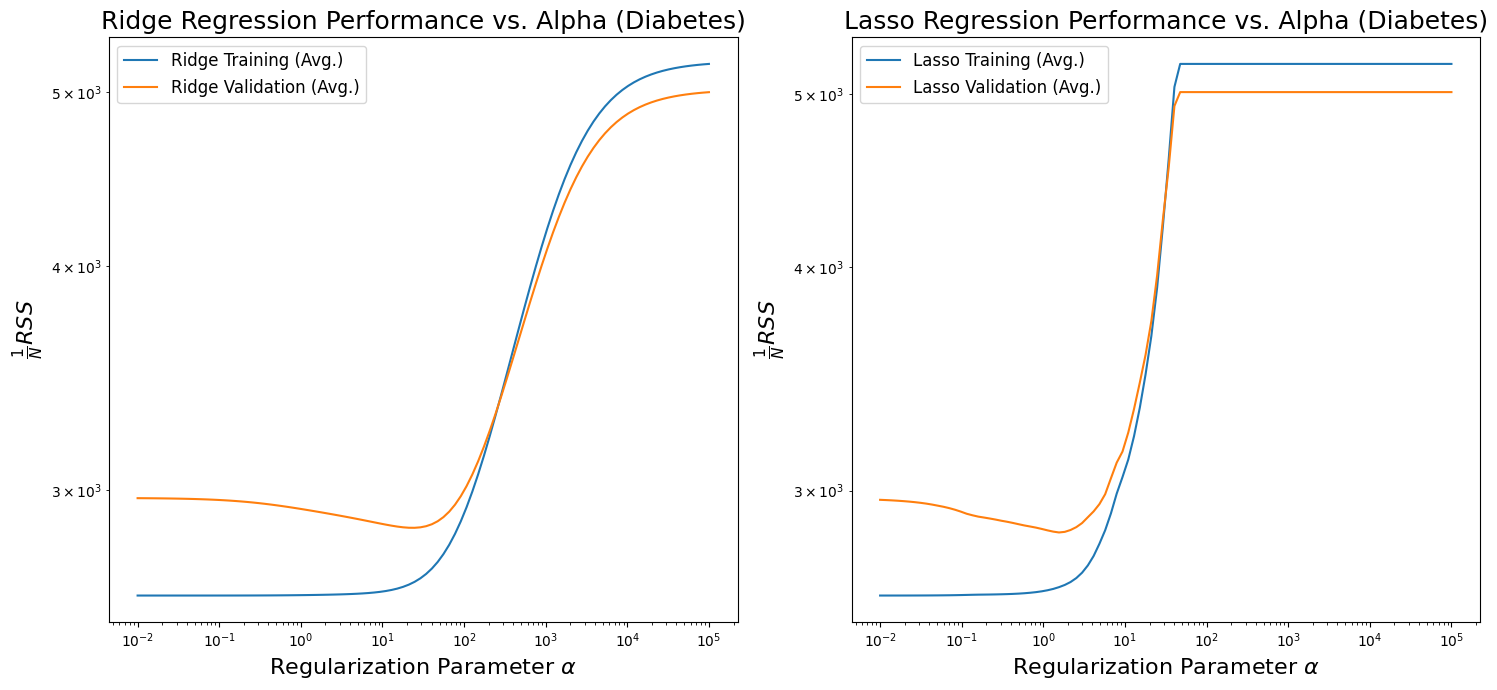


Optimal alpha for Ridge Regression (Diabetes): 24.77076355991709
Optimal alpha for Lasso Regression (Diabetes): 1.5556761439304723


In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes = load_diabetes()
X_diabetes, y_diabetes = diabetes.data, diabetes.target

# Divide the dataset
XTrain_d, XTest_d, yTrain_d, yTest_d = train_test_split(X_diabetes, y_diabetes, train_size=150, test_size=50, random_state=1)

print("Training Samples (Diabetes): ", len(yTrain_d))
print("Testing  Samples (Diabetes): ", len(yTest_d))

# Define the parameters to search for both Ridge and Lasso
param_grid_diabetes = [
    {'ridge__alpha': np.logspace(-2, 5, 100)} # alpha between 0.01 and 100000
]
param_grid_lasso_diabetes = [
    {'lasso__alpha': np.logspace(-2, 5, 100)} # alpha between 0.01 and 100000
]

# --- Ridge Regression Grid Search ---
# Reuse the pipe_regRR pipeline
cv_regRR_d = GridSearchCV(pipe_regRR, param_grid_diabetes, scoring=neg_rss, cv=cv, return_train_score=True)
cv_regRR_d.fit(XTrain_d, yTrain_d)

# --- Lasso Regression Grid Search ---
# Reuse the pipe_regLasso pipeline
cv_regLasso_d = GridSearchCV(pipe_regLasso, param_grid_lasso_diabetes, scoring=neg_rss, cv=cv, return_train_score=True)
cv_regLasso_d.fit(XTrain_d, yTrain_d)

# Visualize performance vs. alpha for both Ridge and Lasso
testedAlpha_RR_d = cv_regRR_d.cv_results_['param_ridge__alpha']
trainScores_RR_d = -cv_regRR_d.cv_results_['mean_train_score']
testScores_RR_d = -cv_regRR_d.cv_results_['mean_test_score']

testedAlpha_Lasso_d = cv_regLasso_d.cv_results_['param_lasso__alpha']
trainScores_Lasso_d = -cv_regLasso_d.cv_results_['mean_train_score']
testScores_Lasso_d = -cv_regLasso_d.cv_results_['mean_test_score']

plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.plot(testedAlpha_RR_d, trainScores_RR_d, '-', label='Ridge Training (Avg.)')
plt.plot(testedAlpha_RR_d, testScores_RR_d, '-', label='Ridge Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.title('Ridge Regression Performance vs. Alpha (Diabetes)', fontsize=18)
plt.legend(loc=2, fontsize=12)

plt.subplot(122)
plt.plot(testedAlpha_Lasso_d, trainScores_Lasso_d, '-', label='Lasso Training (Avg.)')
plt.plot(testedAlpha_Lasso_d, testScores_Lasso_d, '-', label='Lasso Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.title('Lasso Regression Performance vs. Alpha (Diabetes)', fontsize=18)
plt.legend(loc=2, fontsize=12)

plt.tight_layout()
plt.show()

# Find optimal alpha for both models
cvOptAlpha_RR_d = cv_regRR_d.best_params_['ridge__alpha']
cvOptAlpha_Lasso_d = cv_regLasso_d.best_params_['lasso__alpha']

print("\nOptimal alpha for Ridge Regression (Diabetes):", cvOptAlpha_RR_d)
print("Optimal alpha for Lasso Regression (Diabetes):", cvOptAlpha_Lasso_d)